In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-23 23:32:45.172996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 23:32:45.214673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761255165.230357   27296 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761255165.235871   27296 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-23 23:32:45.284455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment. Copy of exp3 with more data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

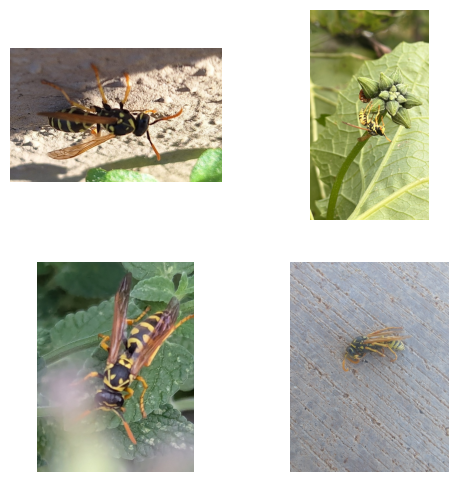

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 26030 images belonging to 127 classes.
Found 6477 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_27296/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761255171.150671   27296 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761255171.151970   27296 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46919 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                         patience = 10,
                                         mode = 'max',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761255182.538167   27551 service.cc:148] XLA service 0x7d2bc0001ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761255182.538190   27551 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761255182.538193   27551 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-23 23:33:02.803246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761255183.896304   27551 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761255185.918813   27551 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255186.042130   27551 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

230/814 ━━━━━━━━━━━━━━━━━━━━ 4:21 447ms/step - accuracy: 0.0381 - loss: 4.7591

E0000 00:00:1761255305.565058   27550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255305.688843   27550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255308.544096   27550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255308.670539   27550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255310.517096   27550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.1401 - loss: 3.9857

E0000 00:00:1761255599.841066   27553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255599.965504   27553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255602.714914   27553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761255602.847612   27553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/ho


Epoch 1: val_average_precision = 0.4435
814/814 ━━━━━━━━━━━━━━━━━━━━ 480s 557ms/step - accuracy: 0.2531 - loss: 3.2002 - val_accuracy: 0.4355 - val_loss: 2.1297 - val_average_precision: 0.4435 - learning_rate: 1.0000e-04
Epoch 2/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4799 - loss: 1.9335
Epoch 2: val_average_precision = 0.5362
814/814 ━━━━━━━━━━━━━━━━━━━━ 380s 467ms/step - accuracy: 0.4934 - loss: 1.8582 - val_accuracy: 0.5180 - val_loss: 1.7790 - val_average_precision: 0.5362 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5821 - loss: 1.5031

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 3: val_average_precision = 0.5968
814/814 ━━━━━━━━━━━━━━━━━━━━ 379s 466ms/step - accuracy: 0.5874 - loss: 1.4752 - val_accuracy: 0.5856 - val_loss: 1.4967 - val_average_precision: 0.5968 - learning_rate: 1.0000e-04
Epoch 4/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6438 - loss: 1.2475
Epoch 4: val_average_precision = 0.6236
814/814 ━━━━━━━━━━━━━━━━━━━━ 381s 468ms/step - accuracy: 0.6393 - loss: 1.2545 - val_accuracy: 0.5938 - val_loss: 1.4374 - val_average_precision: 0.6236 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6820 - loss: 1.0719

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 5: val_average_precision = 0.6315
814/814 ━━━━━━━━━━━━━━━━━━━━ 401s 492ms/step - accuracy: 0.6800 - loss: 1.0828 - val_accuracy: 0.6018 - val_loss: 1.4052 - val_average_precision: 0.6315 - learning_rate: 1.0000e-04
Epoch 6/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7135 - loss: 0.9580
Epoch 6: val_average_precision = 0.6396
814/814 ━━━━━━━━━━━━━━━━━━━━ 380s 466ms/step - accuracy: 0.7113 - loss: 0.9665 - val_accuracy: 0.6114 - val_loss: 1.3982 - val_average_precision: 0.6396 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7474 - loss: 0.8457
Epoch 7: val_average_precision = 0.6539
814/814 ━━━━━━━━━━━━━━━━━━━━ 378s 464ms/step - accuracy: 0.7439 - loss: 0.8509 - val_accuracy: 0.6315 - val_loss: 1.3273 - val_average_precision: 0.6539 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7753 - loss: 0.7449
Epoch 8: val_average_precision = 0.6442
814/814 ━━━━━━━━━━━━━━━━━━━━ 378s 464ms/step - accuracy: 0.7669 - loss: 0.7662 - val_accuracy: 0.6278 - val_loss: 1.4004 - val_average_precision: 0.6442 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7906 - loss: 0.6753
Epoch 9: val_average_precision = 0.6575
814/814 ━━━━━━━━━━━━━━━━━━━━ 377s 463ms/step - accuracy: 0.7890 - loss: 0.6817 - val_accuracy: 0.6389 - val_loss: 1.3684 - val_average_precision: 0.6575 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8123 - loss: 0.6061
Epoch 10: val_average_precision = 0.6599
814/814 ━━━━━━━━━━━━━━━━━━━━ 376s 461ms/step - accuracy: 0.8070 - loss: 0.6273 - val_accuracy: 0.6381 - val_loss: 1.3758 - val_average_precision: 0.6599 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8261 - loss: 0.5442
Epoch 11: val_average_precision = 0.6560
814/814 ━━━━━━━━━━━━━━━━━━━━ 395s 485ms/step - accuracy: 0.8201 - loss: 0.5666 - val_accuracy: 0.6353 - val_loss: 1.4050 - val_average_precision: 0.6560 - learning_rate: 1.0000e-04
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8409 - loss: 0.4920
Epoch 12: val_average_precision = 0.6623
814/814 ━━━━━━━━━━━━━━━━━━━━ 396s 486ms/step - accuracy: 0.8358 - loss: 0.5131 - val_accuracy: 0.6409 - val_loss: 1.4283 - val_average_precision: 0.6623 - learning_rate: 1.0000e-04
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8593 - loss: 0.4455

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 13: val_average_precision = 0.6712
814/814 ━━━━━━━━━━━━━━━━━━━━ 379s 466ms/step - accuracy: 0.8514 - loss: 0.4692 - val_accuracy: 0.6426 - val_loss: 1.4693 - val_average_precision: 0.6712 - learning_rate: 1.0000e-04
Epoch 14/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8688 - loss: 0.4130
Epoch 14: val_average_precision = 0.6534
814/814 ━━━━━━━━━━━━━━━━━━━━ 378s 465ms/step - accuracy: 0.8628 - loss: 0.4321 - val_accuracy: 0.6315 - val_loss: 1.5803 - val_average_precision: 0.6534 - learning_rate: 1.0000e-04
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8786 - loss: 0.3751
Epoch 15: val_average_precision = 0.6519
814/814 ━━━━━━━━━━━━━━━━━━━━ 381s 468ms/step - accuracy: 0.8738 - loss: 0.3941 - val_accuracy: 0.6307 - val_loss: 1.5954 - val_average_precision: 0.6519 - learning_rate: 1.0000e-04
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8850 - loss: 0.3441
Epoch 16: val_average_precision = 0.6527
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 454ms/step - accuracy: 0.8813 - loss: 0.3651 - val_accuracy: 0.6398 - val_loss: 1.5828 - val_average_precision: 0.6527 - learning_rate: 1.0000e-04
Epoch 17/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8984 - loss: 0.3134
Epoch 17: val_average_precision = 0.6535

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
814/814 ━━━━━━━━━━━━━━━━━━━━ 365s 448ms/step - accuracy: 0.8894 - loss: 0.3379 - val_accuracy: 0.6398 - val_loss: 1.5914 - val_average_precision: 0.6535 - learning_rate: 1.0000e-04
Epoch 18/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9235 - loss: 0.2445
Epoch 18: val_average_precision = 0.6796
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 454ms/step - accuracy: 0.9245 - loss: 0.2361 - val_accuracy: 0.6710 - val_loss: 1.3893 - val_average_precision: 0.6796 - learning_rate: 5.0000e-05
Epoch 19/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9394 - loss: 0.1966
Epoch 19: val_average_precision = 0.6795
814/814 ━━━━━━━━━━━━━━━━━━━━ 372s 457ms/step - accuracy: 0.9355 - loss: 0.2028 - val_accuracy: 0.6718 - val_loss: 1.4498 - val_average_precision: 0.6795 - learning_rate: 5.0000e-05
Epoch 20/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9470 - loss: 0.1709
Epoch 20: val_average_precision = 0.6797
814/814 ━━━━━━━━━━━━━━━━━━━━ 373s 458ms/step - accuracy: 0.9415 - loss: 0.1838 - val_accuracy: 0.6628 - val_loss: 1.5076 - val_average_precision: 0.6797 - learning_rate: 5.0000e-05
Epoch 21/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9421 - loss: 0.1725
Epoch 21: val_average_precision = 0.6767
814/814 ━━━━━━━━━━━━━━━━━━━━ 370s 455ms/step - accuracy: 0.9435 - loss: 0.1726 - val_accuracy: 0.6679 - val_loss: 1.5122 - val_average_precision: 0.6767 - learning_rate: 5.0000e-05
Epoch 22/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9513 - loss: 0.1566
Epoch 22: val_average_precision = 0.6786
814/814 ━━━━━━━━━━━━━━━━━━━━ 372s 456ms/step - accuracy: 0.9493 - loss: 0.1619 - val_accuracy: 0.6739 - val_loss: 1.5166 - val_average_precision: 0.6786 - learning_rate: 5.0000e-05
Epoch 23/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9522 - loss: 0.1485
Epoch 23: val_average_precision = 0.6749
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.9499 - loss: 0.1569 - val_accuracy: 0.6660 - val_loss: 1.6006 - val_average_precision: 0.6749 - learning_rate: 5.0000e-05
Epoch 24/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9560 - loss: 0.1399
Epoch 24: val_average_precision = 0.6754
814/814 ━━━━━━━━━━━━━━━━━━━━ 366s 449ms/step - accuracy: 0.9549 - loss: 0.1449 - val_accuracy: 0.6696 - val_loss: 1.5809 - val_average_precision: 0.6754 - learning_rate: 5.0000e-05
Epoch 25/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9561 - loss: 0.1335
Epoch 25: val_average_precision = 0.6798
814/814 ━━━━━━━━━━━━━━━━━━━━ 368s 452ms/step - accuracy: 0.9552 - loss: 0.1398 - val_accuracy: 0.6677 - val_loss: 1.5817 - val_average_precision: 0.6798 - learning_rate: 5.0000e-05
Epoch 26/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9574 - loss: 0.1348
Epoch 26: val_average_precision = 0.6721

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
814/814 ━━━━━━━━━━━━━━━━━━━━ 367s 451ms/step - accuracy: 0.9567 - loss: 0.1371 - val_accuracy: 0.6591 - val_loss: 1.6518 - val_average_precision: 0.6721 - learning_rate: 5.0000e-05
Epoch 27/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9688 - loss: 0.1064
Epoch 27: val_average_precision = 0.6793
814/814 ━━━━━━━━━━━━━━━━━━━━ 370s 454ms/step - accuracy: 0.9683 - loss: 0.1038 - val_accuracy: 0.6736 - val_loss: 1.5795 - val_average_precision: 0.6793 - learning_rate: 2.5000e-05
Epoch 28/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9730 - loss: 0.0897
Epoch 28: val_average_precision = 0.6832
814/814 ━━━━━━━━━━━━━━━━━━━━ 368s 453ms/step - accuracy: 0.9716 - loss: 0.0926 - val_accuracy: 0.6793 - val_loss: 1.5565 - val_average_precision: 0.6832 - learning_rate: 2.5000e-05
Epoch 29/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9720 - loss: 0.0944
Epoch 29: val_average_precision = 0.6773
814/814 ━━━━━━━━━━━━━━━━━━━━ 373s 459ms/step - accuracy: 0.9726 - loss: 0.0914 - val_accuracy: 0.6736 - val_loss: 1.6104 - val_average_precision: 0.6773 - learning_rate: 2.5000e-05
Epoch 30/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9746 - loss: 0.0815
Epoch 30: val_average_precision = 0.6818
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 456ms/step - accuracy: 0.9748 - loss: 0.0815 - val_accuracy: 0.6782 - val_loss: 1.5711 - val_average_precision: 0.6818 - learning_rate: 2.5000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


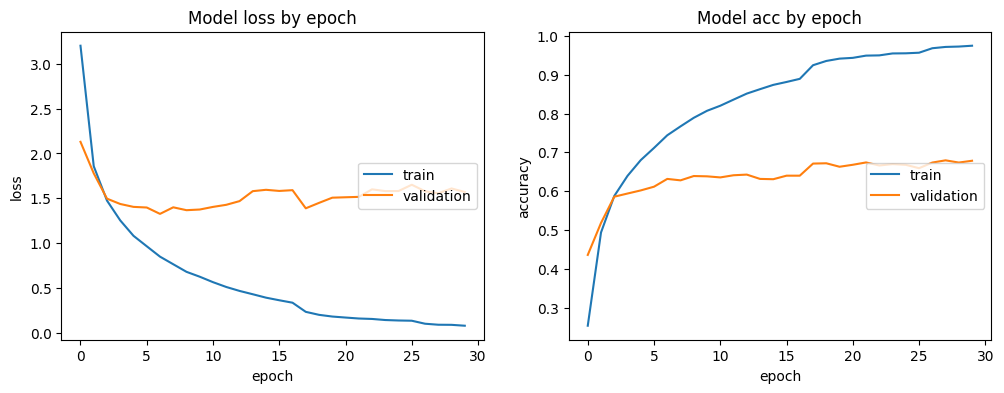

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp7.h5')